# Prepare TopoJSON files for Geographic Visualization of CoW vs UCDP/PRIO

by Jenna Jordan

Note: this notebook should be run in a conda environment with geopandas and topojson packages installed.

In [59]:
import pandas as pd
import numpy as np
import geopandas as gpd
import topojson
import json

## Import Country Shapes to GeoPandas DataFrame

In [2]:
cshapes_df = gpd.read_file("../Data/CShapes/cshapes_0.6/cshapes.shp")
cshapes_df.columns

Index(['CNTRY_NAME', 'AREA', 'CAPNAME', 'CAPLONG', 'CAPLAT', 'FEATUREID',
       'COWCODE', 'COWSYEAR', 'COWSMONTH', 'COWSDAY', 'COWEYEAR', 'COWEMONTH',
       'COWEDAY', 'GWCODE', 'GWSYEAR', 'GWSMONTH', 'GWSDAY', 'GWEYEAR',
       'GWEMONTH', 'GWEDAY', 'ISONAME', 'ISO1NUM', 'ISO1AL2', 'ISO1AL3',
       'geometry'],
      dtype='object')

In [3]:
cshapes_df.head()

,CNTRY_NAME,AREA,CAPNAME,CAPLONG,CAPLAT,FEATUREID,COWCODE,COWSYEAR,COWSMONTH,COWSDAY,...,GWSMONTH,GWSDAY,GWEYEAR,GWEMONTH,GWEDAY,ISONAME,ISO1NUM,ISO1AL2,ISO1AL3,geometry
0,Guyana,211982.004988,Georgetown,-58.2,6.800000,0,110,1966,5,26,...,5,26,2016,6,30,Guyana,328,GY,GUY,"POLYGON ((-58.17262 6.81222, -58.15494 6.82819..."
1,Suriname,145952.274029,Paramaribo,-55.2,5.833333,1,115,1975,11,25,...,11,25,2016,6,30,Suriname,740,SR,SUR,"POLYGON ((-55.12796 5.82217, -55.10445 5.83945..."
2,Trinidad and Tobago,5041.728952,Port-of-Spain,-61.5,10.650000,2,52,1962,8,31,...,8,31,2016,6,30,Trinidad and Tobago,780,TT,TTO,"MULTIPOLYGON (((-61.07945 10.82416, -61.07556 ..."
3,Venezuela,916782.217193,Caracas,-66.9,10.500000,3,101,1946,1,1,...,1,1,2016,6,30,Venezuela,862,VE,VEN,"MULTIPOLYGON (((-66.31029 10.62602, -66.28309 ..."
4,Samoa,2955.212366,Apia,-172.0,-13.800000,4,990,1976,12,15,...,1,1,2016,6,30,Samoa,882,WS,WSM,"MULTIPOLYGON (((-172.59650 -13.50911, -172.551..."


## Create GeoDataFrames for both CoW and G&W (UCDP/PRIO)

Two geodataframes: one for CoW schema (used with CoW wars) and one for G&W schema (used with UCDP/PRIO wars)

Get rid of columns that don't apply to that dataframe's country code schema

Need to transform the date columns into startdate and enddate columns of datetime type - but lose the day specificity, as date granularity will only be saved at the month level

In [4]:
cow_geo_df = cshapes_df[cshapes_df['COWCODE'] != -1].drop(columns=['GWSYEAR', 'GWSMONTH', 'GWSDAY', 'GWEYEAR', 'GWEMONTH', 'GWEDAY', 'ISONAME', 'ISO1NUM', 'ISO1AL2'])
gw_geo_df = cshapes_df[cshapes_df['GWCODE'] != -1].drop(columns=['COWSYEAR', 'COWSMONTH', 'COWSDAY', 'COWEYEAR', 'COWEMONTH', 'COWEDAY','ISONAME', 'ISO1NUM', 'ISO1AL2'])

In [5]:
cow_geo_df['StartDate'] = cow_geo_df['COWSYEAR'].astype(str) + '-' + cow_geo_df['COWSMONTH'].astype(str) + '-01' #+ cow_geo_df['COWSDAY'].astype(str)
cow_geo_df['StartDate'] = pd.to_datetime(cow_geo_df['StartDate'])

cow_geo_df['EndDate'] = cow_geo_df['COWEYEAR'].astype(str) + '-' + cow_geo_df['COWEMONTH'].astype(str) + '-01' #+ cow_geo_df['COWEDAY'].astype(str)
cow_geo_df['EndDate'] = pd.to_datetime(cow_geo_df['EndDate'])

gw_geo_df['StartDate'] = gw_geo_df['GWSYEAR'].astype(str) + '-' + gw_geo_df['GWSMONTH'].astype(str) + '-01' #+ gw_geo_df['GWSDAY'].astype(str)
gw_geo_df['StartDate'] = pd.to_datetime(gw_geo_df['StartDate'])

gw_geo_df['EndDate'] = gw_geo_df['GWEYEAR'].astype(str) + '-' + gw_geo_df['GWEMONTH'].astype(str) + '-01' #+ gw_geo_df['GWEDAY'].astype(str)
gw_geo_df['EndDate'] = pd.to_datetime(gw_geo_df['EndDate'])

Note: These lists will be needed later to trim down the CoW and UCDP/PRIO conflict datasets

In [6]:
cshapes_cowcodes = cow_geo_df['COWCODE'].unique().tolist()
cshapes_gwcodes = gw_geo_df['GWCODE'].unique().tolist()

let's see how many countries change borders and how often

In [7]:
cow_geo_df.groupby('COWCODE').agg({'FEATUREID': 'nunique', 'CNTRY_NAME': lambda x: ', '.join(x), 'StartDate': 'min', 'EndDate': 'max'}).sort_values(by='FEATUREID', ascending=False).head(26)

,FEATUREID,CNTRY_NAME,StartDate,EndDate
COWCODE,,,,
345,6,"Yugoslavia, Yugoslavia, Serbia and Montenegro,...",1946-01-01,2016-06-01
651,5,"Egypt, Egypt, Egypt (United Arab Republic), Eg...",1946-01-01,2016-06-01
600,4,"Morocco, Morocco, Morocco, Morocco",1956-03-01,2016-06-01
850,4,"Indonesia, Indonesia, Indonesia, Indonesia",1949-12-01,2016-06-01
820,3,"Malaysia, Malaysia, Malaysia",1957-08-01,2016-06-01
770,3,"Pakistan, Pakistan, Pakistan",1947-08-01,2016-06-01
365,3,"Russia, USSR, USSR",1946-01-01,2016-06-01
435,3,"Mauritania, Mauritania, Mauritania",1960-11-01,2016-06-01
510,3,"Tanzania, Tanzania, Tanzania",1961-12-01,2016-06-01


In [8]:
gw_geo_df.groupby('GWCODE').agg({'FEATUREID': 'nunique', 'CNTRY_NAME': lambda x: ', '.join(x), 'StartDate': 'min', 'EndDate': 'max'}).sort_values(by='FEATUREID', ascending=False).head(26)

,FEATUREID,CNTRY_NAME,StartDate,EndDate
GWCODE,,,,
365,10,"Russia, USSR, USSR, USSR, USSR, USSR, USSR, US...",1946-01-01,2016-06-01
850,4,"Indonesia, Indonesia, Indonesia, Indonesia",1946-01-01,2016-06-01
600,4,"Morocco, Morocco, Morocco, Morocco",1956-03-01,2016-06-01
510,3,"Tanzania, Tanzania, Tanzania",1961-12-01,2016-06-01
345,3,"Yugoslavia, Serbia and Montenegro, Yugoslavia",1946-01-01,2006-06-01
770,3,"Pakistan, Pakistan, Pakistan",1947-08-01,2016-06-01
435,3,"Mauritania, Mauritania, Mauritania",1960-11-01,2016-06-01
820,3,"Malaysia, Malaysia, Malaysia",1957-08-01,2016-06-01
651,3,"Egypt, Egypt, Egypt",1946-01-01,2016-06-01


## Expand GeoDataFrames into a Time-Series

Note: cannot keep the geometries column for some reason - need to merge this in later. Time-series df is not a geodataframe, only dataframes with geometries are still geodataframes.

code citation for expanding to a time-series from a time range: https://stackoverflow.com/questions/42151886/expanding-pandas-data-frame-with-date-range-in-columns

In [9]:
cow_geo_df_geometries = cow_geo_df[['FEATUREID', 'geometry']]
type(cow_geo_df_geometries)

geopandas.geodataframe.GeoDataFrame

In [10]:
gw_geo_df_geometries = gw_geo_df[['FEATUREID', 'geometry']]
type(gw_geo_df_geometries)

geopandas.geodataframe.GeoDataFrame

In [11]:
cow_geo_df = cow_geo_df.sort_values(by=['COWCODE', 'StartDate', 'FEATUREID'])

cow_geo_ts_df = pd.concat([pd.DataFrame({'month': pd.date_range(row.StartDate, row.EndDate, freq='MS'),
                                         'cow_id': row.COWCODE,
                                         'gw_id': row.GWCODE,
                                         'iso_alpha3': row.ISO1AL3,
                                         'country': row.CNTRY_NAME, 
                                         'FEATUREID': row.FEATUREID}, 
                                columns=['month', 'cow_id', 'iso_alpha3', 'gw_id', 'country', 'FEATUREID']) 
                           for i, row in cow_geo_df.iterrows()], ignore_index=True)
cow_geo_ts_df

,month,cow_id,iso_alpha3,gw_id,country,FEATUREID
0,1946-01-01,2,USA,2,United States,238
1,1946-02-01,2,USA,2,United States,238
2,1946-03-01,2,USA,2,United States,238
3,1946-04-01,2,USA,2,United States,238
4,1946-05-01,2,USA,2,United States,238
...,...,...,...,...,...,...
124074,2016-02-01,990,WSM,990,Samoa,4
124075,2016-03-01,990,WSM,990,Samoa,4
124076,2016-04-01,990,WSM,990,Samoa,4
124077,2016-05-01,990,WSM,990,Samoa,4


In [12]:
gw_geo_df = gw_geo_df.sort_values(by=['GWCODE', 'StartDate', 'FEATUREID'])

gw_geo_ts_df = pd.concat([pd.DataFrame({'month': pd.date_range(row.StartDate, row.EndDate, freq='MS'),
                                        'gw_id': row.GWCODE,
                                        'cow_id': row.COWCODE,
                                        'iso_alpha3': row.ISO1AL3,
                                        'country': row.CNTRY_NAME, 
                                        'FEATUREID': row.FEATUREID}, 
                                columns=['month', 'gw_id', 'iso_alpha3', 'cow_id', 'country', 'FEATUREID']) 
                           for i, row in gw_geo_df.iterrows()], ignore_index=True)
gw_geo_ts_df

,month,gw_id,iso_alpha3,cow_id,country,FEATUREID
0,1946-01-01,2,USA,2,United States,238
1,1946-02-01,2,USA,2,United States,238
2,1946-03-01,2,USA,2,United States,238
3,1946-04-01,2,USA,2,United States,238
4,1946-05-01,2,USA,2,United States,238
...,...,...,...,...,...,...
128891,2016-02-01,990,WSM,990,Samoa,4
128892,2016-03-01,990,WSM,990,Samoa,4
128893,2016-04-01,990,WSM,990,Samoa,4
128894,2016-05-01,990,WSM,990,Samoa,4


create a variable that marks when the borders change

Note: dropping the date specificity to the month level resulted in duplicates in the time series. Keep=last will keep the row with the border change = 1

In [13]:
def find_border_change(x):
    marker = 1
    current_shape = -1
    for i, v in x.iterrows():
        this_shape = x.loc[i, 'FEATUREID']
        if this_shape == current_shape:
            x.loc[i, 'border_change'] = 0
        else:
            x.loc[i, 'border_change'] = 1
            current_shape = this_shape
    return x

In [14]:
cow_geo_ts_df = cow_geo_ts_df.groupby(['cow_id']).apply(find_border_change)
cow_geo_ts_df = cow_geo_ts_df.drop_duplicates(subset=['month', 'cow_id'], keep='last')

In [15]:
gw_geo_ts_df = gw_geo_ts_df.groupby(['gw_id']).apply(find_border_change)
gw_geo_ts_df = gw_geo_ts_df.drop_duplicates(subset=['month', 'gw_id'], keep='last')

add back in the geometry columns and make sure they are geodataframes and haven't lost any data

In [16]:
cow_geo_ts_df.shape, gw_geo_ts_df.shape

((124061, 7), (128872, 7))

In [17]:
cow_geo_ts_df = cow_geo_df_geometries.merge(cow_geo_ts_df, on='FEATUREID')
cow_geo_ts_df

,FEATUREID,geometry,month,cow_id,iso_alpha3,gw_id,country,border_change
0,0,"POLYGON ((-58.17262 6.81222, -58.15494 6.82819...",1966-05-01,110,GUY,110,Guyana,1.0
1,0,"POLYGON ((-58.17262 6.81222, -58.15494 6.82819...",1966-06-01,110,GUY,110,Guyana,0.0
2,0,"POLYGON ((-58.17262 6.81222, -58.15494 6.82819...",1966-07-01,110,GUY,110,Guyana,0.0
3,0,"POLYGON ((-58.17262 6.81222, -58.15494 6.82819...",1966-08-01,110,GUY,110,Guyana,0.0
4,0,"POLYGON ((-58.17262 6.81222, -58.15494 6.82819...",1966-09-01,110,GUY,110,Guyana,0.0
...,...,...,...,...,...,...,...,...
124056,246,"POLYGON ((34.09223 9.47747, 34.09416 9.45472, ...",2016-02-01,626,SSD,626,South Sudan,0.0
124057,246,"POLYGON ((34.09223 9.47747, 34.09416 9.45472, ...",2016-03-01,626,SSD,626,South Sudan,0.0
124058,246,"POLYGON ((34.09223 9.47747, 34.09416 9.45472, ...",2016-04-01,626,SSD,626,South Sudan,0.0
124059,246,"POLYGON ((34.09223 9.47747, 34.09416 9.45472, ...",2016-05-01,626,SSD,626,South Sudan,0.0


In [18]:
cow_geo_ts_df.shape, type(cow_geo_ts_df)

((124061, 8), geopandas.geodataframe.GeoDataFrame)

In [19]:
gw_geo_ts_df = gw_geo_df_geometries.merge(gw_geo_ts_df, on='FEATUREID')
gw_geo_ts_df

,FEATUREID,geometry,month,gw_id,iso_alpha3,cow_id,country,border_change
0,0,"POLYGON ((-58.173 6.812, -58.155 6.828, -58.03...",1966-05-01,110,GUY,110,Guyana,1.0
1,0,"POLYGON ((-58.173 6.812, -58.155 6.828, -58.03...",1966-06-01,110,GUY,110,Guyana,0.0
2,0,"POLYGON ((-58.173 6.812, -58.155 6.828, -58.03...",1966-07-01,110,GUY,110,Guyana,0.0
3,0,"POLYGON ((-58.173 6.812, -58.155 6.828, -58.03...",1966-08-01,110,GUY,110,Guyana,0.0
4,0,"POLYGON ((-58.173 6.812, -58.155 6.828, -58.03...",1966-09-01,110,GUY,110,Guyana,0.0
...,...,...,...,...,...,...,...,...
128867,251,"MULTIPOLYGON (((73.656 39.455, 73.669 39.365, ...",1991-08-01,365,SUN,-1,USSR,1.0
128868,253,"MULTIPOLYGON (((152.221 47.173, 152.207 47.125...",1991-09-01,365,SUN,-1,USSR,1.0
128869,254,"MULTIPOLYGON (((152.221 47.173, 152.207 47.125...",1991-10-01,365,SUN,-1,USSR,1.0
128870,254,"MULTIPOLYGON (((152.221 47.173, 152.207 47.125...",1991-11-01,365,SUN,-1,USSR,0.0


In [20]:
gw_geo_ts_df.shape, type(gw_geo_ts_df)

((128872, 8), geopandas.geodataframe.GeoDataFrame)

## Import CoW conflict data

In [21]:
cow_par = pd.read_csv("../Data/CorrelatesOfWar/war_participants.csv")

In [22]:
cow_par['StartDate'] = pd.to_datetime(cow_par['StartDate'])
cow_par['EndDate'] = cow_par['EndDate'].fillna('2008-12-31')
cow_par['EndDate'] = pd.to_datetime(cow_par['EndDate'])
cow_par['StartDate'] = cow_par['StartDate'].apply(lambda dt: dt.replace(day=1))
cow_par['EndDate'] = cow_par['EndDate'].apply(lambda dt: dt.replace(day=1))

cow_cut = cow_par[cow_par['PolityID'].isin(cshapes_cowcodes)]
cow_cut = cow_cut[(cow_cut['StartDate'] >= '1945-01-01') & (cow_cut['StartDate'] <= '2007-12-31')]

In [23]:
cow_war_ts = pd.concat([pd.DataFrame({'month': pd.date_range(row.StartDate, row.EndDate, freq='MS'),
                                      'cow_id': row.PolityID,
                                      'WarID': row.WarID}, 
                                columns=['month', 'cow_id', 'WarID']) 
                           for i, row in cow_cut.iterrows()], ignore_index=True)
cow_war_ts = cow_war_ts[cow_war_ts['month'] <= '2007-12-31']
cow_war_ts = cow_war_ts.drop_duplicates()
cow_war_ts

,month,cow_id,WarID
0,1945-08-01,712,139
1,1945-08-01,365,139
2,1947-10-01,750,147
3,1947-11-01,750,147
4,1947-12-01,750,147
...,...,...,...
13861,1971-06-01,698,1577
13862,1971-07-01,698,1577
13863,1971-08-01,698,1577
13864,1971-09-01,698,1577


In [24]:
cow_war_ts_gb = cow_war_ts.groupby(['month', 'cow_id']).agg({'WarID': 'count'})
cow_war_ts_gb = cow_war_ts_gb.reset_index().rename(columns={'WarID':'war_count'})
cow_war_ts_gb

,month,cow_id,war_count
0,1945-05-01,290,1
1,1945-05-01,365,3
2,1945-06-01,290,1
3,1945-06-01,365,3
4,1945-07-01,290,1
...,...,...,...
11615,2007-12-01,645,1
11616,2007-12-01,700,1
11617,2007-12-01,732,1
11618,2007-12-01,780,1


In [25]:
cow_war_ts_gb['war_count'].value_counts()

1    9818
2    1561
3     237
4       4
Name: war_count, dtype: int64

## Import UCDP/PRIO conflict data

In [26]:
ucdp_par = pd.read_csv("../Data/UCDP-PRIO_ArmedConflict/participants_gw.csv")
ucdp_obs = pd.read_csv("../Data/UCDP-PRIO_ArmedConflict/observations.csv")
ucdp_eps = pd.read_csv("../Data/UCDP-PRIO_ArmedConflict/episodes.csv")

In [27]:
ucdp_merged = ucdp_par.merge(ucdp_obs[['obs_id', 'intensity_level', 'ep_id']], on=['obs_id']) \
                      .merge(ucdp_eps[['ep_id', 'start_date2', 'ep_end_date']], on=['ep_id'])

ucdp_merged = ucdp_merged[ucdp_merged['gw_id'].isin(cshapes_gwcodes)]
ucdp_merged = ucdp_merged[ucdp_merged['intensity_level'] == 'War']
ucdp_merged = ucdp_merged[ucdp_merged['role'] == 'primary']

ucdp_merged['start_date2'] = pd.to_datetime(ucdp_merged['start_date2'])
ucdp_merged['ep_end_date'] = ucdp_merged['ep_end_date'].fillna('2018-12-31')
ucdp_merged['ep_end_date'] = pd.to_datetime(ucdp_merged['ep_end_date'])
ucdp_merged['start_date2'] = ucdp_merged['start_date2'].apply(lambda dt: dt.replace(day=1))
ucdp_merged['ep_end_date'] = ucdp_merged['ep_end_date'].apply(lambda dt: dt.replace(day=1))
ucdp_merged

,obs_id,gw_id,side,role,conflict_id,year,intensity_level,ep_id,start_date2,ep_end_date
0,200-1946,145,A,primary,200,1946,War,200-1,1946-07-01,1946-07-01
11,202-1946,710,A,primary,202,1946,War,202-1,1946-12-01,1949-12-01
12,202-1947,710,A,primary,202,1947,War,202-1,1946-12-01,1949-12-01
13,202-1948,710,A,primary,202,1948,War,202-1,1946-12-01,1949-12-01
14,202-1949,710,A,primary,202,1949,War,202-1,1946-12-01,1949-12-01
...,...,...,...,...,...,...,...,...,...,...
4304,13692-2001,2,B,primary,13692,2001,War,13692-1,2001-10-01,2001-11-01
4305,13692-2001,200,B,primary,13692,2001,War,13692-1,2001-10-01,2001-11-01
4307,13694-2016,620,A,primary,13694,2016,War,13694-1,2015-03-01,2018-12-01
4318,13902-2016,640,A,primary,13902,2016,War,13902-1,2015-11-01,2017-09-01


In [28]:
ucdp_war_ts = pd.concat([pd.DataFrame({'month': pd.date_range(row.start_date2, row.ep_end_date, freq='MS'),
                                        'gw_id': row.gw_id,
                                        'WarID': row.conflict_id}, 
                                columns=['month', 'gw_id', 'WarID']) 
                           for i, row in ucdp_merged.iterrows()], ignore_index=True)
ucdp_war_ts = ucdp_war_ts[ucdp_war_ts['month'] <= '2018-12-31']
ucdp_war_ts = ucdp_war_ts.drop_duplicates()
ucdp_war_ts

,month,gw_id,WarID
0,1946-07-01,145,200
1,1946-12-01,710,202
2,1947-01-01,710,202
3,1947-02-01,710,202
4,1947-03-01,710,202
...,...,...,...
121579,2018-08-01,840,14275
121580,2018-09-01,840,14275
121581,2018-10-01,840,14275
121582,2018-11-01,840,14275


In [29]:
ucdp_war_ts_gb = ucdp_war_ts.groupby(['month', 'gw_id']).agg({'WarID': 'count'})
ucdp_war_ts_gb = ucdp_war_ts_gb.reset_index().rename(columns={'WarID':'war_count'})
ucdp_war_ts_gb

,month,gw_id,war_count
0,1946-03-01,350,1
1,1946-04-01,350,1
2,1946-05-01,350,1
3,1946-06-01,350,1
4,1946-06-01,365,1
...,...,...,...
12517,2018-12-01,678,1
12518,2018-12-01,700,2
12519,2018-12-01,750,1
12520,2018-12-01,770,1


In [30]:
ucdp_war_ts_gb['war_count'].value_counts()

1    10775
2     1277
3      328
4      142
Name: war_count, dtype: int64

## Merge conflict data with geospatial data

In [31]:
cow_final_gdf = cow_geo_ts_df.merge(cow_war_ts_gb, on=['cow_id', 'month'], how='left')
cow_final_gdf['war_count'] = cow_final_gdf['war_count'][cow_final_gdf['month'] <= '2007-12-31'].fillna(0)
#cow_final_gdf['month'] = cow_final_gdf['month'].astype(str)
cow_final_gdf

,FEATUREID,geometry,month,cow_id,iso_alpha3,gw_id,country,border_change,war_count
0,0,"POLYGON ((-58.17262 6.81222, -58.15494 6.82819...",1966-05-01,110,GUY,110,Guyana,1.0,0.0
1,0,"POLYGON ((-58.17262 6.81222, -58.15494 6.82819...",1966-06-01,110,GUY,110,Guyana,0.0,0.0
2,0,"POLYGON ((-58.17262 6.81222, -58.15494 6.82819...",1966-07-01,110,GUY,110,Guyana,0.0,0.0
3,0,"POLYGON ((-58.17262 6.81222, -58.15494 6.82819...",1966-08-01,110,GUY,110,Guyana,0.0,0.0
4,0,"POLYGON ((-58.17262 6.81222, -58.15494 6.82819...",1966-09-01,110,GUY,110,Guyana,0.0,0.0
...,...,...,...,...,...,...,...,...,...
124056,246,"POLYGON ((34.09223 9.47747, 34.09416 9.45472, ...",2016-02-01,626,SSD,626,South Sudan,0.0,NaN
124057,246,"POLYGON ((34.09223 9.47747, 34.09416 9.45472, ...",2016-03-01,626,SSD,626,South Sudan,0.0,NaN
124058,246,"POLYGON ((34.09223 9.47747, 34.09416 9.45472, ...",2016-04-01,626,SSD,626,South Sudan,0.0,NaN
124059,246,"POLYGON ((34.09223 9.47747, 34.09416 9.45472, ...",2016-05-01,626,SSD,626,South Sudan,0.0,NaN


In [32]:
cow_final_gdf.duplicated(subset=['month', 'cow_id']).sum()

0

In [33]:
ucdp_final_gdf = gw_geo_ts_df.merge(ucdp_war_ts_gb, on=['gw_id', 'month'], how='left')
ucdp_final_gdf['war_count'] = ucdp_final_gdf['war_count'].fillna(0).astype('int')
#ucdp_final_gdf['month'] = ucdp_final_gdf['month'].astype(str)
ucdp_final_gdf

,FEATUREID,geometry,month,gw_id,iso_alpha3,cow_id,country,border_change,war_count
0,0,"POLYGON ((-58.173 6.812, -58.155 6.828, -58.03...",1966-05-01,110,GUY,110,Guyana,1.0,0
1,0,"POLYGON ((-58.173 6.812, -58.155 6.828, -58.03...",1966-06-01,110,GUY,110,Guyana,0.0,0
2,0,"POLYGON ((-58.173 6.812, -58.155 6.828, -58.03...",1966-07-01,110,GUY,110,Guyana,0.0,0
3,0,"POLYGON ((-58.173 6.812, -58.155 6.828, -58.03...",1966-08-01,110,GUY,110,Guyana,0.0,0
4,0,"POLYGON ((-58.173 6.812, -58.155 6.828, -58.03...",1966-09-01,110,GUY,110,Guyana,0.0,0
...,...,...,...,...,...,...,...,...,...
128867,251,"MULTIPOLYGON (((73.656 39.455, 73.669 39.365, ...",1991-08-01,365,SUN,-1,USSR,1.0,0
128868,253,"MULTIPOLYGON (((152.221 47.173, 152.207 47.125...",1991-09-01,365,SUN,-1,USSR,1.0,0
128869,254,"MULTIPOLYGON (((152.221 47.173, 152.207 47.125...",1991-10-01,365,SUN,-1,USSR,1.0,0
128870,254,"MULTIPOLYGON (((152.221 47.173, 152.207 47.125...",1991-11-01,365,SUN,-1,USSR,0.0,0


In [34]:
ucdp_final_gdf.duplicated(subset=['month', 'gw_id']).sum()

0

In [35]:
type(cow_final_gdf), type(ucdp_final_gdf)

(geopandas.geodataframe.GeoDataFrame, geopandas.geodataframe.GeoDataFrame)

## Visualize

In [115]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import geoplot
import ipywidgets as widgets
import mapclassify as mc

In [ ]:
cow_month_by_month = cow_final_gdf.groupby("month")
cow_groups = dict(list(cow_month_by_month))

ucdp_month_by_month = ucdp_final_gdf.groupby("month")
ucdp_groups = dict(list(ucdp_month_by_month))

time_strings = [t.strftime('%Y %b') for t in ucdp_groups.keys()]

In [103]:
date_slider = widgets.SelectionSlider(options=cow_groups.keys(),
                                      description='Date (month)',
                                      layout={'width': '500px'})
def on_dateslider_change(change):
    date_selected = change['new']
    df = cow_month_by_month.get_group(date_selected)

date_slider.observe(on_dateslider_change, ['value'])
date_slider

SelectionSlider(description='Date (month)', layout=Layout(width='500px'), options=(Timestamp('1946-01-01 00:00…

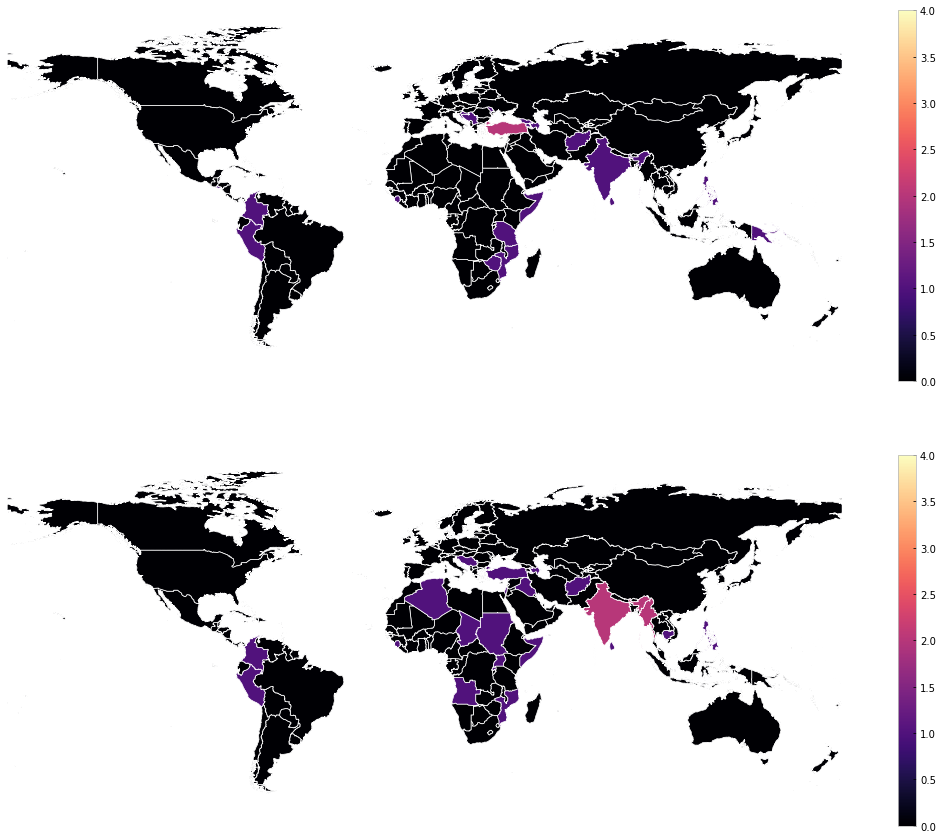

In [131]:
norm = mpl.colors.Normalize(vmin=0,vmax=4)

fig = plt.figure(figsize=(20, 15))
top_ax = fig.add_subplot(211)
bottom_ax = fig.add_subplot(212)

cow_df = cow_month_by_month.get_group('1992-01-01')
cow_map = geoplot.choropleth(cow_df, ax=top_ax,
                            hue='war_count', 
                            cmap='magma', 
                            norm=norm, 
                            figsize=(20,10), 
                            legend=True,
                            edgecolor='white', 
                            linewidth=0.75)

ucdp_df = ucdp_month_by_month.get_group('1992-01-01')
ucdp_map = geoplot.choropleth(ucdp_df, ax=bottom_ax,
                            hue='war_count', 
                            cmap='magma', 
                            norm=norm, 
                            figsize=(20,10), 
                            legend=True,
                            edgecolor='white', 
                            linewidth=0.75)